## Mod 6 Lecture 4 Data Challenge:  Simple Linear Regression

### Purpose

**Purpose**: Run a simple linear regression (SLR) on the NYC Yellow Taxi Dec 2023 excerpt to explain how a single input (X) relates to Tip % (Y). Practice picking a sensible X, fitting the line, and interpreting β₁, p‑value, and 95% confidence interval—plus basic assumption checks.

### Data
We are looking at ONE month's worth of data (December 2023 to be exact).  Remember the data dictionary is found [HERE](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data)

### Instructor Guidance (10 Minutes)

#### Goals

- Pick an X with a plausible relationship to Tip % that is available at trip time.

- Communicate β₁ with units, p-vale, and a 95% CI.

#### Special considerations

- `Tip %` is `tip_amount / fare_amount`. Choosing `fare_amount` as X can create a built‑in relationship because it’s in the definition of Y (mathematical coupling). Encourage alternative X’s like `trip_distance`, `pickup_hour (as numeric)`, or `passenger_count`.

- Linearity check: Is the relationship roughly straight‑line? If X is discrete (e.g., passenger_count), SLR still works but discuss meaning.

- Intercept meaning: If X=0 is unrealistic (0 miles), say the intercept is just a mathematical anchor.

- Outliers: Large distances/fares can dominate. Consider trimming extremes thoughtfully or explaining how you would handle outliers.  

#### Critical thinking prompts as you work through the challenge (be prepared to answer at the end):

- Which input would you use to make a decision before the ride starts? Why?

- If β₁ is tiny but the p‑value is very small, is that useful for the business?

- If residuals (can only get residuals after fitting the model) "fan out" as X grows, what story might that tell about tipping behavior?

- Would your conclusion change if you looked at daytime vs. late night rides separately?

### Student Tasks (35 minutes)

Step 0 — Load Packages and Data, Fix Data Types, Create Tip % Column 

**Hint**:  You did this in the Code-Along, refer back to the notebook to help you!

In [11]:
# import packages
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv', low_memory=False)

Step 1 — Choose Your X (be sure to chose an X variable that would be available at trip time (not after the trip takes place))

Add a 2–3 sentence rationale in Markdown: Why could X relate to `tip_pct`? Why is it available **when the decision is made** (meaning driver has the information before the actual drive takes place)?
- I chose passenger_count as my X variable because the driver can see how many riders are in the taxi before the trip starts. This variable could relate to tip_pct since tipping behavior may vary depending on group size; for example, larger groups might tip more collectively, or split the fare and tip less per person. Understanding this relationship can help identify how group dynamics influence tipping patterns.

In [3]:
# trip_time
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10,5.0,0.5,0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3,0.0,1.0,31.4,2.5,0.0


In [4]:
df.keys()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

Step 2 — Quick Visual Check (Linearity & Outliers)

Add a 2-3 sentence rationale on how you would handle outliers or how you did handle outliers (if you handled them for this challenge).  Is the linear relationship there between your X and Y?  Is it a strong relationship?  What is the benefits of a strong relationship between X and Y?
- I would handle outliers by removing trips with unrealistic passenger counts (for example, more than 6 passengers, since most NYC taxis only allow up to 6). The relationship between passenger count and tip percentage appears weak and not strongly linear. Most tips seem similar regardless of group size. A strong linear relationship would make it easier to predict tips accurately and understand how group size influences tipping behavior.

Step 3 — Fit SLR Model to Data

In [16]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
    )

In [17]:
# Clean data some and add a new column called 'tip_pct' as the target 
df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & (df['trip_distance'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
df['tip_pct'] = (df['tip_amount']/df['fare_amount']).clip(0,1)

In [19]:
# Drop rows with missing values in passenger_count or tip_pct
df = df.dropna(subset=['passenger_count', 'tip_pct'])

# Define X and y
X = df[['passenger_count']]
y = df['tip_pct']

# Create and fit the model
lin = LinearRegression().fit(X, y)

# Print coefficients
print(f"Intercept (β₀): {lin.intercept_}")
print(f"Slope (β₁): {lin.coef_[0]}")


Intercept (β₀): 0.21216545933498546
Slope (β₁): -0.0051002882017328905


Step 4 — Interpret the model's coefficients, p-values, and CI 

The model suggests that when there are 0 passengers, the predicted tip percentage is around 21.2% (the intercept). The slope (-0.0051) means that for each additional passenger, the tip percentage decreases slightly by about 0.5 percentage points. This indicates a very weak negative relationship, suggesting that group size has little to no meaningful impact on tipping behavior.

Step 5 — Post‑Fit Assumption Glance 

Add 2-3 sentences about the residuals any curve? funnel shape? obvious outliers?  How would you go about checking if residuals were normally distributed?  

In [20]:
#RUN THIS CELL WITHOUT CHANGES
resid = ols.resid
fitted = ols.fittedvalues
plt.figure(figsize=(5,4))
plt.scatter(fitted, resid, s=6, alpha=0.3)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values (tip_pct)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (visual check)')
plt.show()

NameError: name 'ols' is not defined

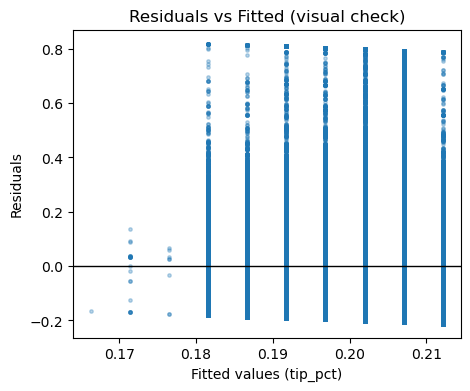

In [22]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Add constant term
X = sm.add_constant(df[['passenger_count']])

# Fit model
ols = sm.OLS(y, X).fit()

# Plot residuals vs fitted values
resid = ols.resid
fitted = ols.fittedvalues

plt.figure(figsize=(5,4))
plt.scatter(fitted, resid, s=6, alpha=0.3)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values (tip_pct)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (visual check)')
plt.show()



### Reflection (10-15 mins)

**In addition to the critical thinking questions at the top** of the notebook be prepared to discuss: 

- If you had to make a decision tomorrow, would this simple model be enough? Why/why not?
    - I wouldn’t rely on this simple model to make a decision tomorrow because the relationship between passenger count and tip percentage is really weak. There isn’t enough evidence that group size actually affects tipping in a meaningful way.

- What’s one different X you’d try next and why?
     - I would try fare_amount because that has a direct impact on how much passengers tip. It makes sense that hte total fare could influence tipping behavior because people tend to base their tips on a percentage of the fare amount. 